In [ ]:
!pip install kaggle

In [1]:
import os
from google.colab import files
import pandas as pd
import cv2
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

In [2]:
!kaggle datasets download -d raniaaprilia/faceshape-dataset

Dataset URL: https://www.kaggle.com/datasets/raniaaprilia/faceshape-dataset
License(s): unknown
100% 984M/987M [00:38<00:00, 25.9MB/s]
100% 987M/987M [00:38<00:00, 26.9MB/s]


In [3]:
!unzip faceshape-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/training_set/Oval/oval (444).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (445).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (446).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (447).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (448).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (449).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (45).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (450).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (451).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (452).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (453).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (456).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (457).jpg  
  inflating: FaceShape Dataset/training_set/Oval/oval (458).jpg  
  inflating: FaceShape Dat

In [4]:
class_names=['Heart', 'Oblong', 'Oval', 'Round', 'Square']
lable = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes= len(class_names)
IMAGE_SIZE=(150, 150)

In [ ]:
upload = files.upload()

KeyboardInterrupt: 

In [ ]:
!kaggle datasets download -d sergiovirahonda/shape-predictor-68-face-landmarksdat

Dataset URL: https://www.kaggle.com/datasets/sergiovirahonda/shape-predictor-68-face-landmarksdat
License(s): unknown
 98% 68.0M/69.3M [00:05<00:00, 17.9MB/s]
100% 69.3M/69.3M [00:05<00:00, 14.2MB/s]


In [ ]:
!unzip /content/shape-predictor-68-face-landmarksdat.zip

Archive:  /content/shape-predictor-68-face-landmarksdat.zip
  inflating: shape_predictor_68_face_landmarks.dat  


In [5]:
def load_data():
  datasets =['/content/FaceShape Dataset/training_set','/content/FaceShape Dataset/testing_set']
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print("Loading {}.".format(dataset))
    for folder in os.listdir(dataset):
      if folder != "desktop.ini" and folder != ".ipynb_checkpoints":
        label = lable[folder]
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
          if file != "desktop.ini":
            img = os.path.join(os.path.join(dataset, folder), file)
            try:
              image = cv2.imread(img)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              image = cv2.GaussianBlur(image, (5, 5), 0)
              clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
              image = clahe.apply(image)
              edges = cv2.Canny(image, 100, 200)
              image = cv2.resize(edges, IMAGE_SIZE)
              images.append(image)
              labels.append(label)
            except Exception as e:
              print(f"Broken: {e,img}")
            continue
    images = np.array(images, dtype ='float32')
    labels = np.array(labels, dtype='int32')
    output.append((images, labels))
  return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/FaceShape Dataset/training_set.


 54%|█████▎    | 859/1603 [00:17<00:08, 83.67it/s]

Broken: (error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n"), '/content/FaceShape Dataset/training_set/Oblong/oblong (724).jpg')


100%|██████████| 1801/1801 [00:29<00:00, 60.67it/s]


Loading /content/FaceShape Dataset/testing_set.


100%|██████████| 299/299 [00:05<00:00, 52.51it/s]


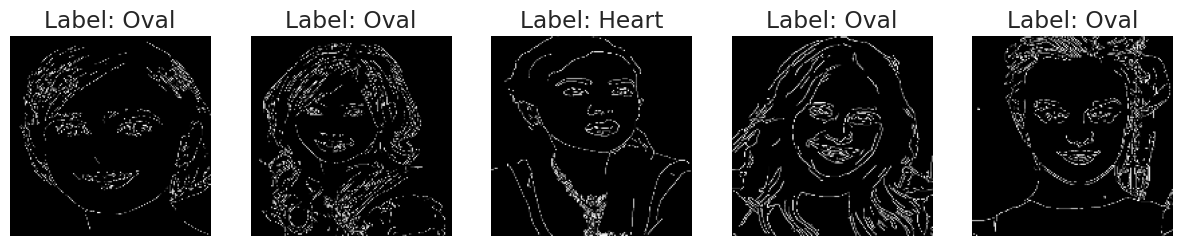

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    idx = np.random.randint(len(train_images))
    ax.imshow(train_images[idx], cmap='gray')
    ax.set_title(f"Label: {class_names[train_labels[idx]]}")
    ax.axis('off')
plt.show()

In [9]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [10]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))


train_images = train_images / 255.0
test_images = test_images / 255.0

Number of training examples: 8801
Number of testing examples: 1478
Each image is of size: (150, 150)


In [11]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(60, (3, 3), activation = 'relu', input_shape = (150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(50, (3, 3), activation = 'relu', input_shape = (150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(40, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(30, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(65, activation=tf.nn.softmax),
    tf.keras.layers.Dropout(0.2)

])

In [12]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
55/55 [==============================] - 10s 175ms/step - loss: 1.8558 - accuracy: 0.7207 - val_loss: 2.2554 - val_accuracy: 0.7513
Epoch 2/10
55/55 [==============================] - 9s 167ms/step - loss: 1.9181 - accuracy: 0.7119 - val_loss: 2.2631 - val_accuracy: 0.7564
Epoch 3/10
55/55 [==============================] - 9s 170ms/step - loss: 1.8097 - accuracy: 0.7241 - val_loss: 2.3632 - val_accuracy: 0.7422
Epoch 4/10
55/55 [==============================] - 9s 163ms/step - loss: 1.8715 - accuracy: 0.7185 - val_loss: 2.3643 - val_accuracy: 0.7445
Epoch 5/10
55/55 [==============================] - 9s 162ms/step - loss: 1.9326 - accuracy: 0.7061 - val_loss: 2.3621 - val_accuracy: 0.7456
Epoch 6/10
55/55 [==============================] - 9s 161ms/step - loss: 1.8497 - accuracy: 0.7189 - val_loss: 2.2757 - val_accuracy: 0.7479
Epoch 7/10
55/55 [==============================] - 9s 161ms/step - loss: 1.8635 - accuracy: 0.7149 - val_loss: 2.4253 - val_accuracy: 0.7354
Epoch

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 60)      600       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 60)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 50)        27050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 50)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 36, 36, 50)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 50)        2

In [61]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

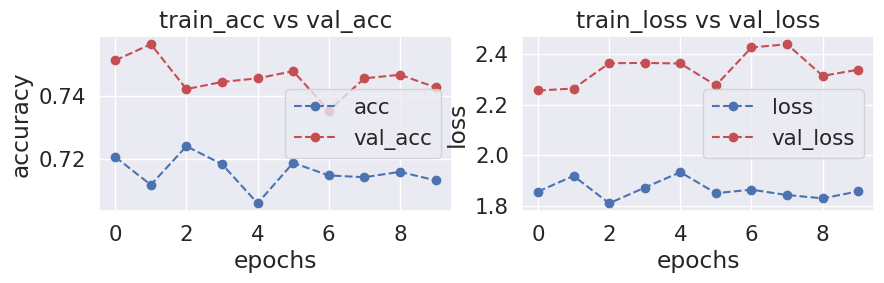

In [62]:
plot_accuracy_loss(history)

In [63]:
test_loss = model.evaluate(test_images, test_labels)

47/47 [==============================] - 0s 10ms/step - loss: 2.8105 - accuracy: 0.6996


In [64]:
def display_random_image(class_names, images, labels):
    """
    #Exibição de uma imagem aleatória
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

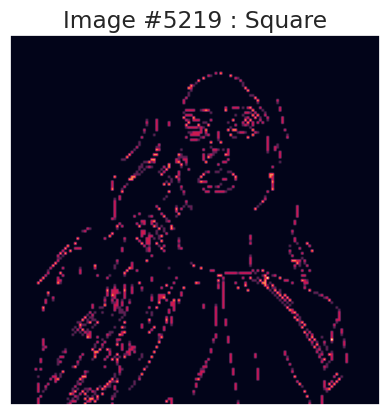

In [65]:
display_random_image(class_names, train_images, train_labels)

47/47 [==============================] - 0s 9ms/step


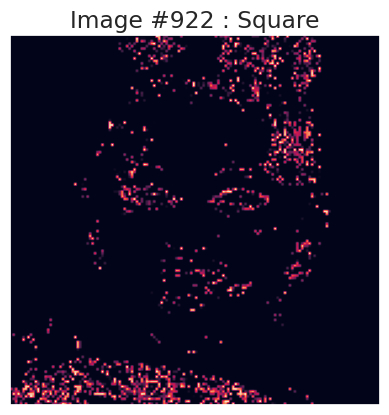

In [68]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

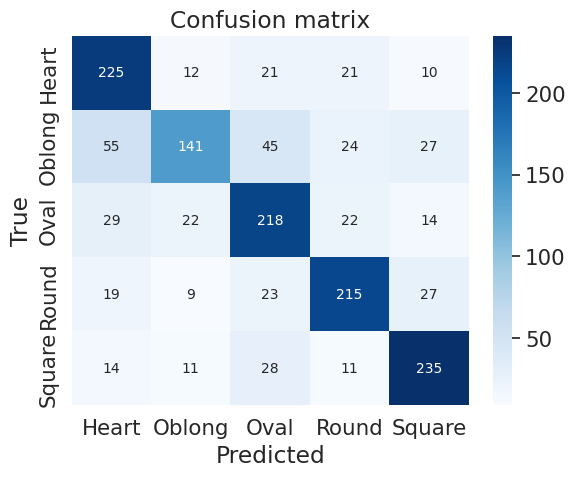

In [69]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           fmt ='d',
           cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [70]:
# Confusion Matriks
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)
# Recall
from sklearn.metrics import recall_score
recall_score(test_labels, pred_labels, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(test_labels, pred_labels, average=None)

#f1-score
from sklearn.metrics import f1_score
f1_score(test_labels, pred_labels, average=None)

#Classification Report
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(test_labels, pred_labels, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       Heart       0.66      0.78      0.71       289
      Oblong       0.72      0.48      0.58       292
        Oval       0.65      0.71      0.68       305
       Round       0.73      0.73      0.73       293
      Square       0.75      0.79      0.77       299

    accuracy                           0.70      1478
   macro avg       0.70      0.70      0.70      1478
weighted avg       0.70      0.70      0.70      1478



In [71]:
model.save('face_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/content/face_classifier.h5')

Saving ca304569-fff7-4ab7-b28a-3290426b6093.jfif to ca304569-fff7-4ab7-b28a-3290426b6093 (3).jfif
1/1 [==============================] - 0s 20ms/step


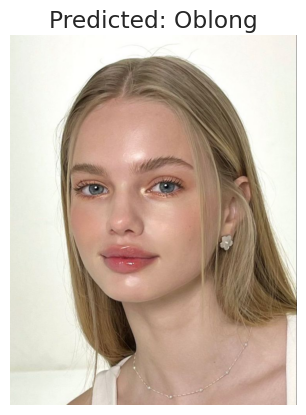

Predicted: Oblong
Probabilitas: 0.993748664855957


In [72]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(filename):
    img = image.load_img(filename, target_size=(150, 150))
    img = image.img_to_array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # x = image.img_to_array(img)
    # x = np.expand_dims(x, axis=-1)
    x = np.expand_dims(img, axis=0)
    x = x / 255.0
    return x

# Unggah file gambar
uploaded = files.upload()

# Memuat dan memproses gambar
for filename in uploaded.keys():
    img_tensor = load_and_preprocess_image(filename)

    # Lakukan prediksi menggunakan model
    predictions = model.predict(img_tensor)

    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image.load_img(filename))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    print(f"Predicted: {predicted_label}")
    print(f"Probabilitas: {predictions[0][predicted_class]}")

In [ ]:
!pip3 install zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [73]:
import os
import shutil
import zipfile

# Set the source directory
source_dir = "/content/FaceShape Dataset"

# Create a ZIP file name
zip_file = "FaceShape_Dataset.zip"

# Create a ZIP file at the current directory
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
    # Iterate over all files and directories in the source directory
    for dirpath, dirnames, filenames in os.walk(source_dir):
        for filename in filenames:
            # Construct the full path of the file
            file_path = os.path.join(dirpath, filename)

            # Create the archive path by removing the source directory from the file path
            archive_path = os.path.relpath(file_path, source_dir)

            # Add the file to the ZIP archive
            zip_ref.write(file_path, arcname=archive_path)

print(f"The dataset has been saved to {zip_file}")

KeyboardInterrupt: 

In [74]:
# Save the model in TensorFlow SavedModel format
import os
from tensorflow.python.saved_model.save import save

saved_model_path = os.path.join('/tmp/', 'mymodel/saved_model.h5')
model.save(saved_model_path)

In [75]:
!pip3 install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
     

In [1]:
!cd /tmp/mymodel/
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /tmp/mymodel/saved_model.h5 /tmp/tfjs_model_faced_shape

2024-06-20 07:17:06.682670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 07:17:08.236682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!zip -r /tmp/tfjs_model_faced_shape/modeldata.zip /tmp/tfjs_model_faced_shape/

updating: tmp/tfjs_model_faced_shape/ (stored 0%)
updating: tmp/tfjs_model_faced_shape/model.json (deflated 86%)
updating: tmp/tfjs_model_faced_shape/group1-shard1of1.bin (deflated 7%)
